# M5 Forecasting

[Introduction](#Introduction)


[EDA](#EDA)

To-do
- Denoising

Statistical Model
- ARIMA
- Exponential Smoothing
- Theta Method

Machine Learning Model
- GBM
- LSTM
Multi-step ahead forecasting

# Introduction
## Goal
Predict Sales data provided by Walmart **28** days into the future

## Data
sales_train.csv: this is our main training data. It has 1 column for each of the 1941 days from 2011-01-29 and 2016-05-22; not including the validation period of 28 days until 2016-06-19. It also includes the IDs for item, department, category, store, and state. The number of rows is 30490 for all combinations of 30490 items and 10 stores.

sell_prices.csv: the store and item IDs together with the sales price of the item as a weekly average.

calendar.csv: dates together with related features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0).

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [3]:
sales = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
price = pd.read_csv('sell_prices.csv')

In [4]:
sales.shape

(30490, 1919)

In [35]:
sales.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,3,0,1,1,1,3,0,1,1,600
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,1,0,0,0,0,493
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,2,1,1,1,0,1,1,1,288
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,5,4,1,0,1,3,7,2,3288
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,1,1,2,2,2,4,1849
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,1,0,0,0,2,0,0,1642
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,1,0,0,1,1,424
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,1,37,3,4,6,3,2,1,13830
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,1,1,6,0,0,0,0,0,2269
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,0,0,0,0,2,0,2,1376


- There is a general id column, and item,dept, category, store, and state id extracted from the general id
- There are many 0 values in the sales values

In [6]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## EDA 

### EDA on Sales

In [7]:
sales['store_id'].nunique()

10

In [8]:
sales['total_sales'] = sales.sum(axis=1)

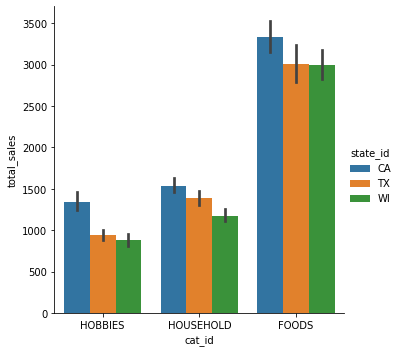

In [9]:
sns.catplot(x = 'cat_id',y='total_sales',data=sales,hue='state_id',kind='bar')

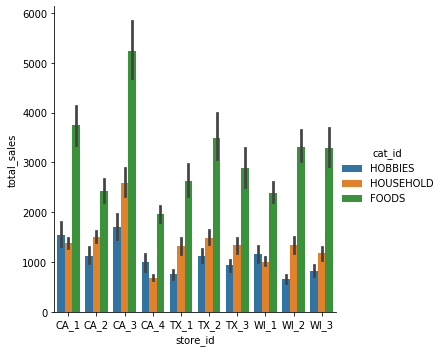

In [32]:
sns.catplot(x ='store_id',y='total_sales',data=sales,hue='cat_id',kind='bar')

### Merge Sales and Calendar Data
- Change D_1 to date?

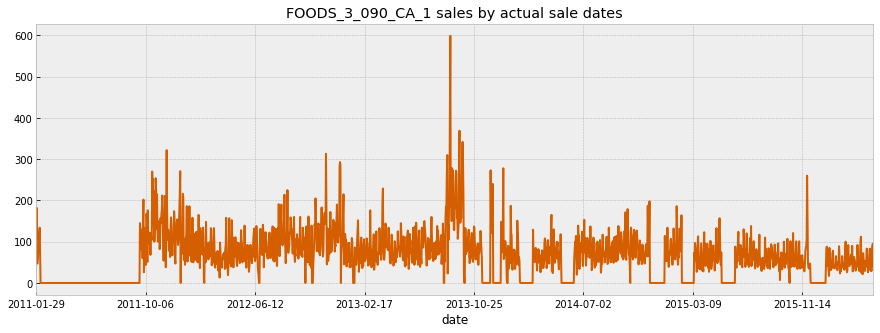

In [56]:
example = sales.loc[sales['id'] == 'FOODS_3_090_CA_1_validation'][day_cols].T
example = example.rename(columns={2314:'FOODS_3_090_CA_1'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(calendar, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_1'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_1 sales by actual sale dates')
plt.show()

### Sample a Random Item and Visualize

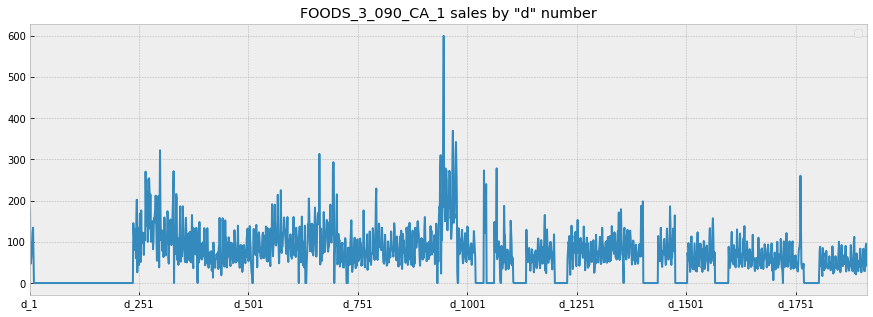

In [39]:
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
day_cols = [c for c in sales.columns if 'd_' in c]
sales.loc[sales['id'] == 'FOODS_3_090_CA_1_validation'] \
    .set_index('id')[day_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_1 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

### Avg sales grouped by category and state
- Merge mean sales with calendar data 

In [125]:
hobbies_state = sales.loc[sales['cat_id']=='HOBBIES'].groupby('state_id').mean().T.\
    rename({'CA': 'HOBBIES_CA', 'TX': 'HOBBIES_TX', 'WI': 'HOBBIES_WI'}, axis=1).drop('total_sales')
hobbies_state['d'] = hobbies_state.index
hobbies_state = hobbies_state.merge(calendar, how='left',validate='1:1').reset_index().rename(columns={'index': 'd'})

household_state = sales.loc[sales['cat_id']=='HOUSEHOLD'].groupby('state_id').mean().T.\
    rename({'CA': 'HOUSEHOLD_CA', 'TX': 'HOUSEHOLD_TX', 'WI': 'HOUSEHOLD_WI'}, axis=1).drop('total_sales')
household_state['d'] = household_state.index
household_state = household_state.merge(calendar, how='left',validate='1:1').reset_index().rename(columns={'index': 'd'})

foods_state = sales.loc[sales['cat_id']=='FOODS'].groupby('state_id').mean().T.\
    rename({'CA': 'FOODS_CA', 'TX': 'FOODS_TX', 'WI': 'FOODS_WI'}, axis=1).drop('total_sales')
foods_state['d'] = foods_state.index
foods_state = foods_state.merge(calendar, how='left',validate='1:1').reset_index().rename(columns={'index': 'd'})


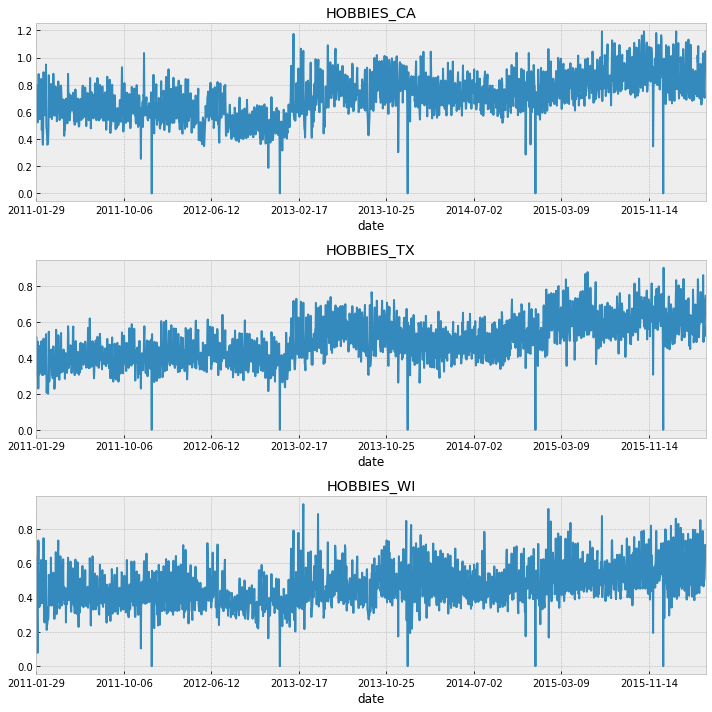

In [96]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
ax_idx =0
for col in ['HOBBIES_CA', 'HOBBIES_TX', 'HOBBIES_WI']:
    hobbies_state.set_index('date')[col].plot(title = col,ax=axs[ax_idx])
    color=next(color_cycle)
    ax_idx +=1
    plt.tight_layout()

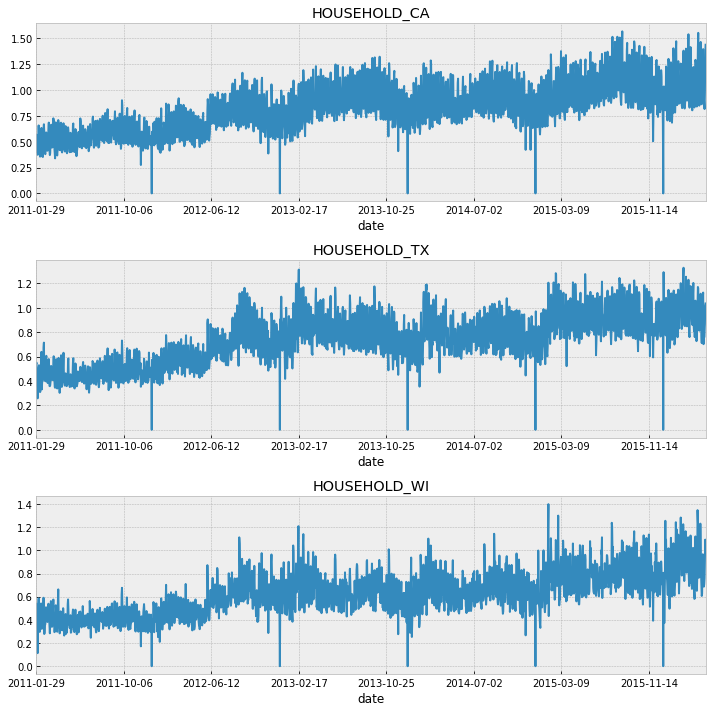

In [95]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
ax_idx =0
for col in ['HOUSEHOLD_CA', 'HOUSEHOLD_TX', 'HOUSEHOLD_WI']:
    household_state.set_index('date')[col].plot(title = col,ax=axs[ax_idx])
    color=next(color_cycle)
    ax_idx +=1
    plt.tight_layout()

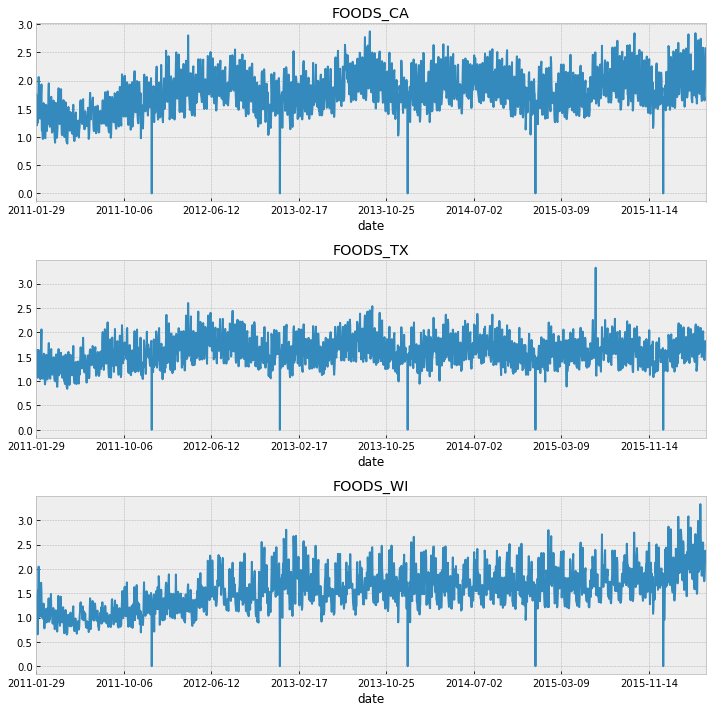

In [94]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
ax_idx =0
for col in ['FOODS_CA', 'FOODS_TX', 'FOODS_WI']:
    foods_state.set_index('date')[col].plot(title = col,ax=axs[ax_idx])
    color=next(color_cycle)
    ax_idx +=1
    plt.tight_layout()

### Trend by Day of Week, Year, Month

HOBBIES_CA


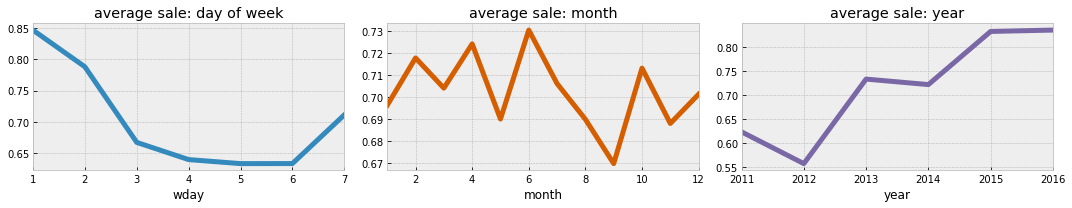

HOBBIES_TX


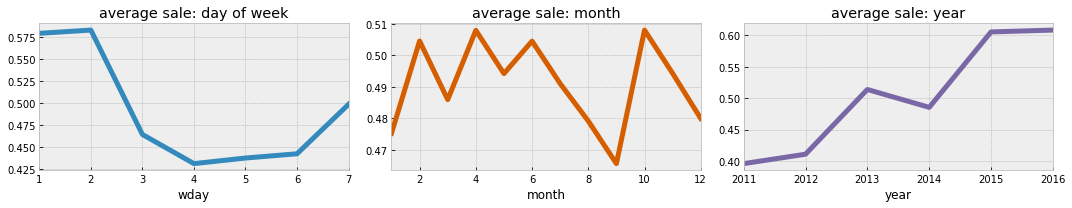

HOBBIES_WI


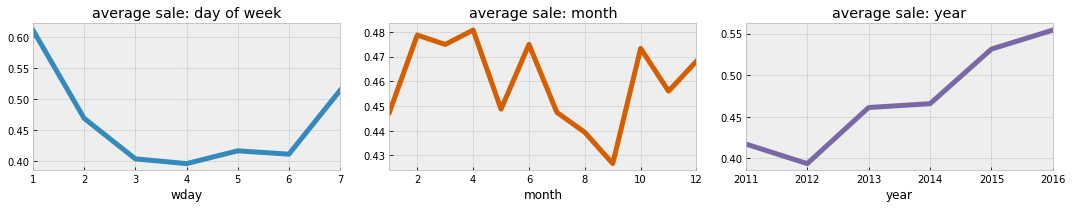

In [114]:
cat_state_df = [hobbies_state, household_state, foods_state]  
hobbies_col = ['HOBBIES_CA', 'HOBBIES_TX', 'HOBBIES_WI']
household_col = ['HOUSEHOLD_CA', 'HOUSEHOLD_TX', 'HOUSEHOLD_WI']
food_col = ['FOODS_CA', 'FOODS_TX', 'FOODS_WI']


for col in hobbies_col:
    print(col)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    #fig.suptitle('Trends for Hobbies')
    ax1.set_title('CA')
    ax2.set_title('TX')
    ax3.set_title('WI')
    hobbies_state.groupby('wday').mean()[col] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    hobbies_state.groupby('month').mean()[col] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],
              ax=ax2)
    hobbies_state.groupby('year').mean()[col] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)
    plt.tight_layout()
    plt.show()

HOUSEHOLD_CA


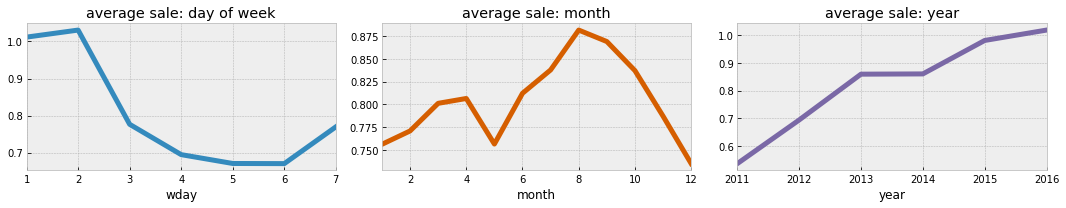

HOUSEHOLD_TX


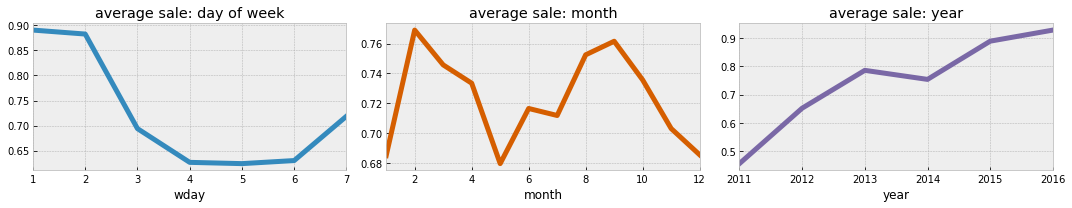

HOUSEHOLD_WI


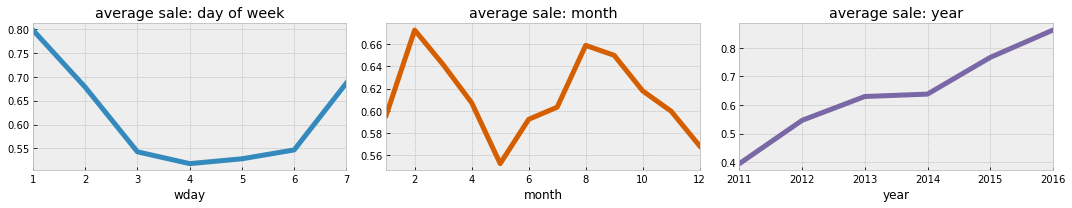

In [116]:
for col in household_col:
    print(col)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    #fig.suptitle('Trends for Hobbies')
    ax1.set_title('CA')
    ax2.set_title('TX')
    ax3.set_title('WI')
    household_state.groupby('wday').mean()[col] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    household_state.groupby('month').mean()[col] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],
              ax=ax2)
    household_state.groupby('year').mean()[col] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)
    plt.tight_layout()
    plt.show()

FOODS_CA


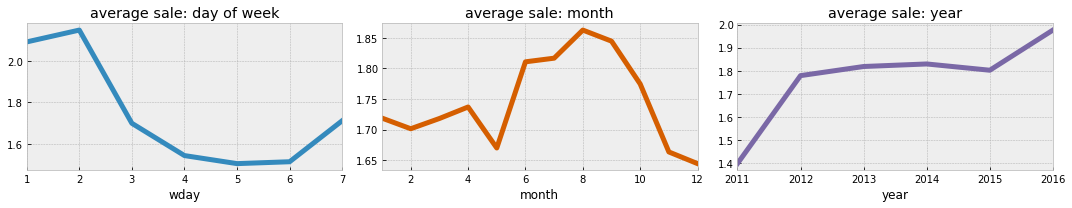

FOODS_TX


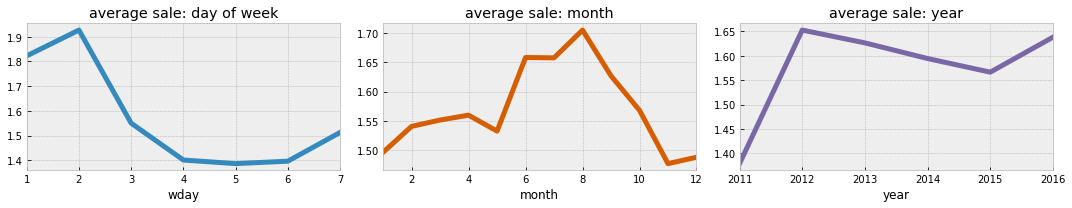

FOODS_WI


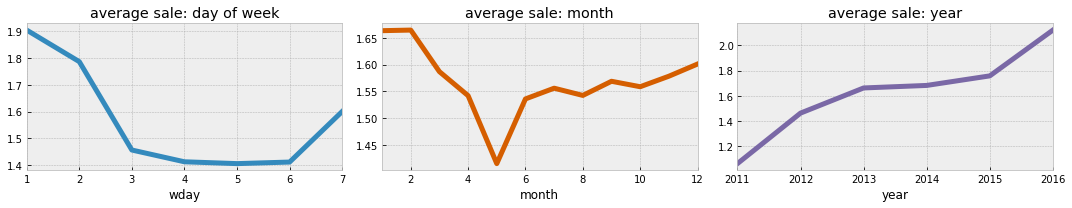

In [126]:
for col in food_col:
    print(col)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    #fig.suptitle('Trends for Hobbies')
    ax1.set_title('CA')
    ax2.set_title('TX')
    ax3.set_title('WI')
    foods_state.groupby('wday').mean()[col] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    foods_state.groupby('month').mean()[col] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],
              ax=ax2)
    foods_state.groupby('year').mean()[col] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)
    plt.tight_layout()
    plt.show()

# Modeling
do we need to denoise? 
on what level should we group?
when highly right skewed, take the log
## Moving Average
- Compute the means sales over previous 30 days and forecast it as next day's sales 
- y_predict = avg(y of y_i to y_i-30)
- predict on store level and state level
- if want to predict sales of future 28 days, those 28 days' true sales should be held for evaluation, not used in prediction computation. can use predict value tho.
- so for test data day1 = avg of previous 30 days, then day2 = avg of previous 30 days including 1st prediction

In [143]:
predictions = []
train_dataset = sales[day_cols[-100:-30]]
val_dataset = sales[day_cols[-30:]]
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
predictions

[array([1.1       , 0.26666667, 0.46666667, ..., 1.2       , 0.96666667,
        1.83333333]),
 array([1.11896552, 0.25402299, 0.47471264, ..., 1.22068966, 0.98333333,
        1.86494253]),
 array([1.12616995, 0.25517241, 0.48534483, ..., 1.24802956, 1.00535714,
        1.88885468]),
 array([1.0760411 , 0.25893997, 0.49704662, ..., 1.24108283, 1.02959656,
        1.85711435]),
 array([1.05264707, 0.26396564, 0.50970211, ..., 1.26757141, 1.05581152,
        1.89206907]),
 array([1.06738236, 0.26987677, 0.52334729, ..., 1.27773735, 1.04407652,
        1.8936314 ]),
 array([1.0451005 , 0.2765537 , 0.53806835, ..., 1.26709257, 1.02790348,
        1.93582878]),
 array([1.06361817, 0.28397378, 0.55398272, ..., 1.25344931, 1.00805323,
        1.87519505]),
 array([1.06334756, 0.26943688, 0.57123627, ..., 1.23711466, 0.98482263,
        1.82642421]),
 array([1.06343576, 0.27611319, 0.59000597, ..., 1.21816961, 1.00586784,
        1.84183932]),
 array([1.0888354 , 0.2837361 , 0.46050567, ..., 1

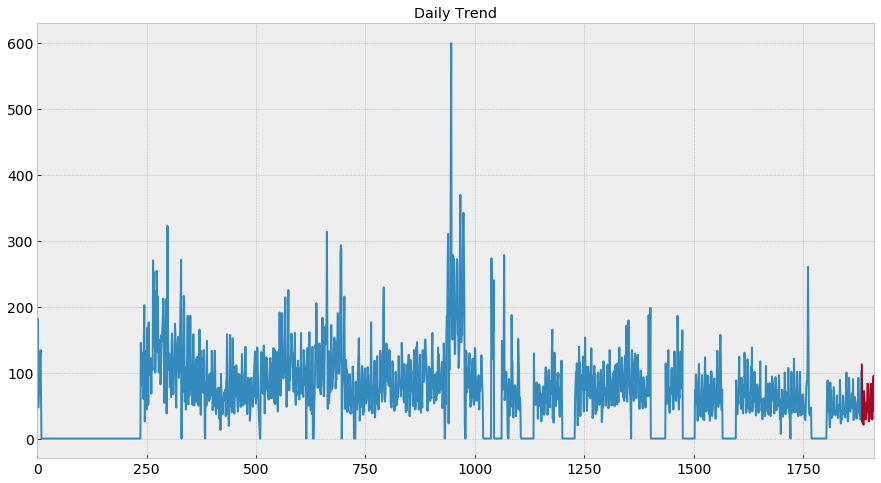

In [154]:
# Create Train Test set
train_ex = example[:1884]
test_ex = example[1884:]
train_ex.FOODS_3_090_CA_1.plot(figsize=(15,8), title= 'Daily Trend', fontsize=14)
test_ex.FOODS_3_090_CA_1.plot(figsize=(15,8), title= 'Daily Trend', fontsize=14)
plt.show()
#example['FOODS_3_090_CA_1'].rolling(30).mean()

In [149]:
example.columns

Index(['d', 'FOODS_3_090_CA_1', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [60]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


## ARIMAX

## FB Prophet

In [131]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [133]:
!conda install fbprophet

Solving environment: failed with current_repodata.json, will retry with next repodata source.
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - fbprophet

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


